In [27]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [28]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
tensor([35], dtype=torch.uint8)


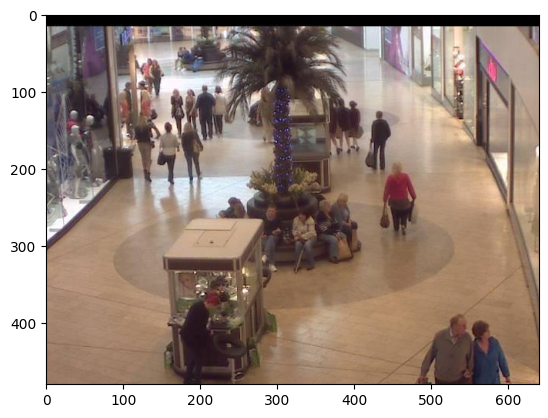

In [29]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [30]:
# Add this cell before defining Net
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Original image shape: {images.shape}")
print(f"After permute: {images.permute(0, 3, 2, 1).shape}")
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 =  nn.Conv2d(32, 64, 5)
        self.bn3 = nn.BatchNorm2d(64)

        self.adaptive_pool = nn.AdaptiveMaxPool2d((12, 12))

        self.fc1 = nn.Linear(64*12*12, 120)
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [31]:
def plot_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [32]:
def train(network, device):
    test_acc = np.zeros(50)
    train_acc = np.zeros(50)
    for epoch in range(50):  # loop over the dataset multiple times
        correct = 0
        total = 0
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            # print(inputs.permute(0, 3, 2, 1).shape)
            # print(labels[0])

            # print(inputs.shape[0]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_acc += torch.mean(torch.abs(outputs.float() - labels)).item() * labels.size(0)
            running_loss += loss.item()

            # print statistics
        train_acc[epoch] = running_acc/total
        print(running_loss)
        total = 0
        running_acc = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data

                images = images.to(device)
                labels = labels.to(device).float()

                outputs = net(images.permute(0, 3, 2, 1).float())
                #_, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)


                error = torch.mean(torch.abs(outputs.float() - labels)).item()
                running_acc += error * labels.size(0)
        test_acc[epoch] = running_acc/total
    plot_graphs("Simple CNN - Linear Regression Model", train_acc, test_acc, "CNN_Plots")

In [33]:
net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)

cuda
281090.87957668304
11707.165951609612
2145.0785765349865
1195.9426366314292
879.0140887908638
712.1292253769934
610.8835491221398
879.6078036129475
1138.720920175314
11333.646203562617
16144.120596528053
7497.922091603279
3216.3948404192924
1819.3856774792075
993.5476007908583
631.8782493323088
537.0817252919078
494.05031291022897
444.82473289594054
760.6590057611465
1335.4305047877133
8062.077118635178
19412.343048930168
18597.742319583893
18170.273407936096
17918.28470379114
14996.1215569973
9108.995869338512
4354.588675051928
2429.6425344645977
1621.3399367630482
1165.091184951365
858.7732402831316
939.5184184536338
950.6840537171811
1039.011388629675
1043.9415279701352
1040.5185439996421
910.0934273526073
726.3891104385257
970.3475841805339
1238.0491932407022
1238.1858050972223
880.8721362650394
655.5550449676812
490.40282447170466
480.029195740819
508.95279137417674
599.8864481449127
756.1601803153753


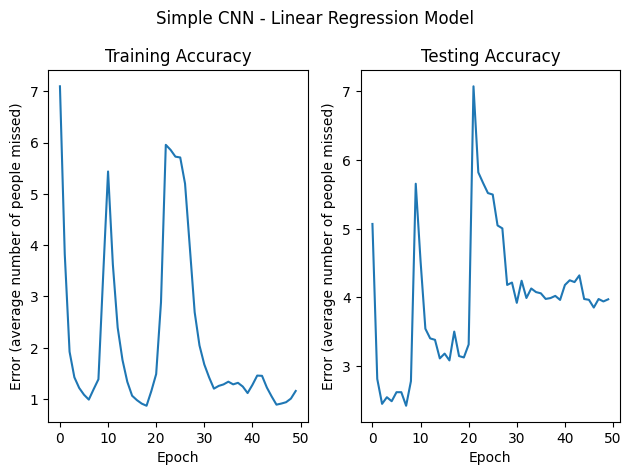

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)
train(net, device)

Predicted:  tensor([22.8362], device='cuda:0', grad_fn=<SelectBackward0>) tensor([23.7943], device='cuda:0', grad_fn=<SelectBackward0>) tensor([36.0007], device='cuda:0', grad_fn=<SelectBackward0>) tensor([37.5456], device='cuda:0', grad_fn=<SelectBackward0>)
Truth:  tensor([31], dtype=torch.uint8) tensor([23], dtype=torch.uint8) tensor([34], dtype=torch.uint8) tensor([33], dtype=torch.uint8)
Average error on the test images (in number of people missed): 3.971935 


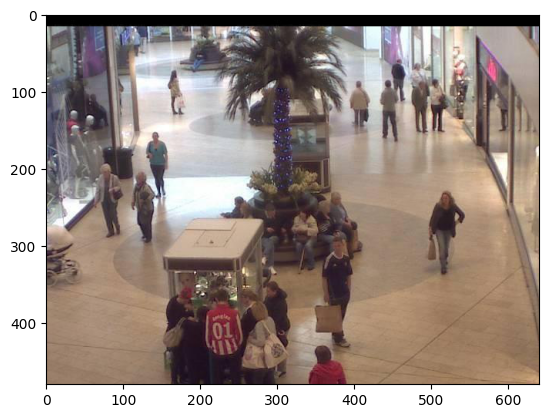

In [35]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = net(images.to(device).permute(0, 3, 2, 1).float())

# _, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % outputs[j]
                              for j in range(4)))
# print images
imshow(images[0])


print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

total = 0.0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images.permute(0, 3, 2, 1).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)


        error = torch.mean(torch.abs(outputs - labels))
        batch_size = labels.size(0)
        total_error += error * batch_size

#print('Accuracy of the network on the 10000 test images: %d %%' % (
    #100 * correct / total))

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))
